In [26]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

import tqdm

%matplotlib inline

import sherlock # eset kivizsgalo szimulator

In [27]:
df = pd.read_csv("./data/Dataset_Anomaly_Init_R2.csv")  # dataset
sec = pd.read_csv("./data/Dataset_Anomaly_Secret_R2.csv")  # megoldas

In [28]:
df.head()

1   2   3  4  5   6  7  8  9  10  11  12  13  14  15  16  ID
0  8  10  12  8  9  10  6  2  5   9   5   7   8   7   2   8   0
1  4   2   5  3  3   8  6  6  4   6   7   8   7   6   2   6   1
2  2   0   3  1  1   7  8  4  0   7   8   8   7   9   0   8   2
3  2   3   3  2  2   7  9  5  4   7   6   7   5   9   2   7   3
4  5   9   8  7  5   7  9  2  4  10   5   6   5   9   1   7   4

In [29]:
df.shape

(2467, 17)

In [30]:
# odaadjuk az eset kivizsgalonak a megoldasokat es meghatarozunk egy budzset, ahanyszor kerdezhetunk toluk - 111
expert = sherlock.Sherlock(sec, 111)

In [31]:
expert.stat()

Adathalmaz mérete   = 2467
Ismert esetek száma = 0 		max: 111


In [32]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, random_state=42)
input_variables = list(df.columns)[:8]
input_variables

['1', '2', '3', '4', '5', '6', '7', '8']

In [33]:
isolation_forest.fit(df[input_variables])
df["isolation_forest_flag"] = isolation_forest.predict(df[input_variables])
df["isolation_forest_flag"].value_counts()

isolation_forest_flag
 1    2034
-1     433
Name: count, dtype: int64

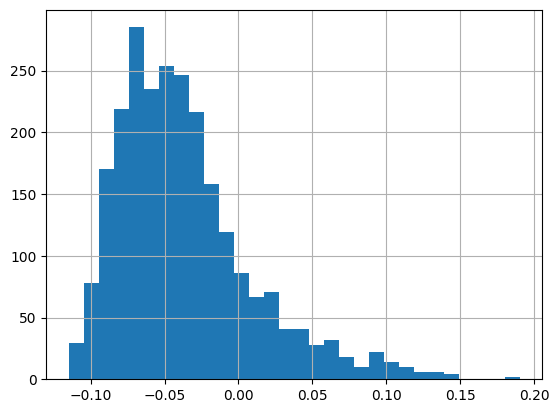

In [34]:
df["isolation_forest_score"] = (
    isolation_forest.decision_function(df[input_variables]) * -1
)
df["isolation_forest_score"].hist(bins=30)
plt.show()

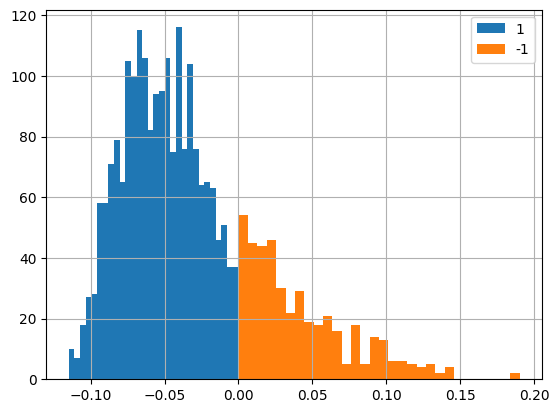

In [35]:
for i in [1, -1]:
    cdf = df[df["isolation_forest_flag"] == i]
    cdf["isolation_forest_score"].hist(bins=30, label=str(i))
plt.legend()
plt.show()

In [36]:
def top10investigate(df, variable, num=10):
    reduced_df = df[df["info"] == "no_info"]
    selected = reduced_df.sort_values(variable, ascending=False).head(num)
    expert.investigate(selected["ID"])
    df2 = expert.add_label(reduced_df, "info")
    return df2

In [37]:
df = top10investigate(df, "isolation_forest_score")

	Nyomozás eredménye	2460	->	csalás
	Nyomozás eredménye	2279	->	ok
	Nyomozás eredménye	976	->	ok
	Nyomozás eredménye	950	->	ok
	Nyomozás eredménye	1106	->	csalás
	Nyomozás eredménye	1693	->	ok
	Nyomozás eredménye	629	->	csalás
	Nyomozás eredménye	2367	->	ok
	Nyomozás eredménye	2399	->	csalás
	Nyomozás eredménye	2153	->	ok


AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
df["info"].value_counts()

In [ ]:
selected = df[df["info"] == "no_info"].sample(20, random_state=42)
expert.investigate(selected["ID"])

# Second approach to detect anomalies

- KMeans clustering
  - randomstate = 42
  - 16 clusters
  - no normalization
  - based on first 9 variables
- Calculate distance from cluster center for each point
- Use this value as anomaly score: check the first 10 values

In [40]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=16, random_state=42)
input_variables = list(df.columns)[:9]
cluster.fit(df[input_variables])
new = []
for i in range(cluster.n_clusters):
    name = f"distance_from_cluster_{i}"
    df[name] = 0
    new.append(name)
df[new] = cluster.transform(df[input_variables])
df["cluster_id"] = cluster.predict(df[input_variables])
df["my_cluster_dist"] = df.apply(
    lambda x: df[f"distance_from_cluster_{str(x['cluster_id'])}"], axis=1
)
df["my_cluster_dist"].hist(bins=30)

/usr/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyError: 'distance_from_cluster_4.0'

# Mini task

Create a function that produces a diagram where:
- 